In [9]:
from skimage.feature import hog
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# KNN
from sklearn.neighbors import KNeighborsClassifier

# SVM
from sklearn.svm import SVC

In [3]:
dataset_path = [os.path.join(os.getcwd(), '..', '..', 'training_dataset', 'dataset (1)')]


def get_image (type: str, num: int = 1):
  return Image.open(os.path.join(os.getcwd(), '..', '..', 'training_dataset', 'dataset (1)', type, f'Image_{num}.jpg'))
img_other = Image.open(os.path.join(os.getcwd(), '..', '..', 'images', 'bus_1.jpg'))

In [4]:
IMAGE_WIDTH = 480
IMAGE_HEIGHT = 270

In [224]:
def thresholding_image(image):
    # Convert to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Thresholding using otsu
    _, otsu_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel_close = np.ones((5, 5), np.uint8)
    otsu_new = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel_close)

    # Thresholding using edges
    edges = cv2.Canny(image, threshold1=275, threshold2=300)

    res = cv2.bitwise_xor(edges, otsu_new)
    res = cv2.medianBlur(res, 3)
    kernel_res = np.ones((3, 3), np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel_res)
    return res

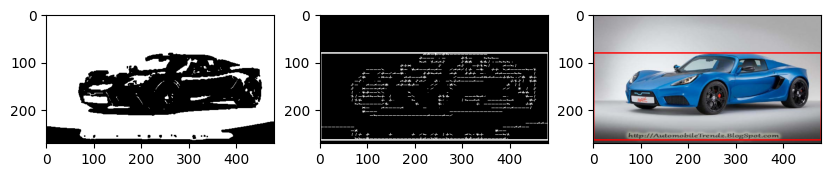

In [223]:
def preprocess_image(pil_image, target_feature_size):
    
    # Convert PIL image to numpy array
    img_init = np.array(pil_image)

    # Resize the image
    img_resized = cv2.resize(img_init, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Use consistent size
    
    thresholded_img = thresholding_image(img_resized)

    # Extract HOG features and visualization
    hog_features, hog_image = hog(
        thresholded_img, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        transform_sqrt=True,
        visualize=True
    )
    
    # Find the coordinates of the bounding box for HOG features
    maxval_hog = np.amax(hog_image)
    binary_mask = (hog_image > maxval_hog*0.1).astype(np.uint8)  # Create a binary mask
    coords = cv2.findNonZero(binary_mask)  # Find non-zero coordinates
    
    # Determine bounding box based on non-zero pixels
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)  # Get bounding box
        top_left = (x, y)
        bottom_right = (x + w, y + h)
    else:
        top_left = (0, 0)
        bottom_right = (IMAGE_WIDTH, IMAGE_HEIGHT)  # Default to full image if no features

    cv2.rectangle(binary_mask, top_left, bottom_right, 1, 2)

    bounded_img = img_resized.copy()
    cv2.rectangle(bounded_img, top_left, bottom_right, (255,0,0), 2)

    plt.figure(figsize=(10, 5))
    # Only to show
    plt.subplot(1, 3, 1)
    plt.imshow(thresholded_img, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(bounded_img)

    # Adjust the features to match the target size
    if len(hog_features) > target_feature_size:
        hog_features = hog_features[:target_feature_size]  # Trim excess features
    else:
        hog_features = np.pad(hog_features, (0, target_feature_size - len(hog_features)), mode='constant')  # Pad with zeros
        
    return hog_features, bounded_img

feat, bounded_img = preprocess_image(get_image("car", 45), 1000)
